In [1]:
%cd ..

C:\Users\bloic\Desktop\Promutuel_technique


In [2]:
from os.path import join
from config import *

from itertools import cycle

import pandas as pd
import numpy as np

import json
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, lasso_path
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from haversine import haversine, Unit

import warnings
warnings.filterwarnings('ignore')

# Séléction de features

Admettons que l’on veuille fixer le prix d’une location de logement dans Québec, quelles sont les features qui ont le plus d’impacte sur un modèle de *Machine Learning* ?

Pour tester ce point, nous allons utiliser des modèles classiques tels que :  
- Un arbre de régression
- Une régression linéaire
- Un Lasso

Ce *notebook* aurait très bien pu s’insérer dans la partie modèle.  
Or, nous réservons cette partie pour le test de plusieurs autres modèles de réseaux de neurones, du boosting, etc..

In [3]:
# On se focalise sur le listing
df_listings = pd.read_csv(join(DATA_DIR, 'listings_data.csv'))

# Prétraitement des données

Nous récupérons une portion du code de la section EDA afin de conserver seulement les variables numériques.

In [4]:
regex = re.compile('[$,]')
df_listings['price'] = df_listings['price'].apply(lambda x: regex.sub('', x)).astype(np.float)

# Sélection de features intéressantes
num_cols = ~(df_listings.dtypes == 'object')
num_cols = num_cols[num_cols].index.to_list()
features = []
# On enlève les IDs
for col in num_cols:
    if 'id' not in col:
        features.append(col)
df_listings[features].dtypes

features.remove('license')
features.remove('calendar_updated')
features.remove('bathrooms')
features.remove('neighbourhood_group_cleansed')
# Les features non informels
features.remove('latitude')
features.remove('longitude')

# 0 chambres quand non renseigné
df_listings['bedrooms'].fillna(0., inplace=True)
# Au moins 1 lit
df_listings['beds'].fillna(1., inplace=True)
# Les scores par catégories --> (a+b) / 2 pour ne pas "pénaliser" le manque de note. Note comprise dans l’intervalle [a, b]
df_listings['review_scores_rating'].fillna(50., inplace=True)
df_listings['review_scores_cleanliness'].fillna(5., inplace=True)
df_listings['review_scores_checkin'].fillna(5., inplace=True)
df_listings['review_scores_communication'].fillna(5., inplace=True)
df_listings['review_scores_location'].fillna(5., inplace=True)
df_listings['review_scores_value'].fillna(5., inplace=True)

# Pour ne pas perturber et ajouter de l’information, pour ces valeurs on attribue à 0 l’accuracy
df_listings['review_scores_accuracy'].fillna(0., inplace=True)
df_listings['reviews_per_month'].fillna(0., inplace=True) # Pareil pour le nombre de reviews

# Le prix n’est pas une feature
features.remove('price')
y_data = df_listings['price'].to_numpy()

df = df_listings[features]

# Observation des données sous PCA

In [5]:
pca = PCA(n_components=2)

X_data = df.to_numpy()
X_pca = pca.fit_transform(X_data)

pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(array([0.82505573, 0.11960653]), 0.9446622613144195)

Les 2 composantes principales expliquent à elles seules $\approx 94.5\%$ de la variation dans le jeu de données.

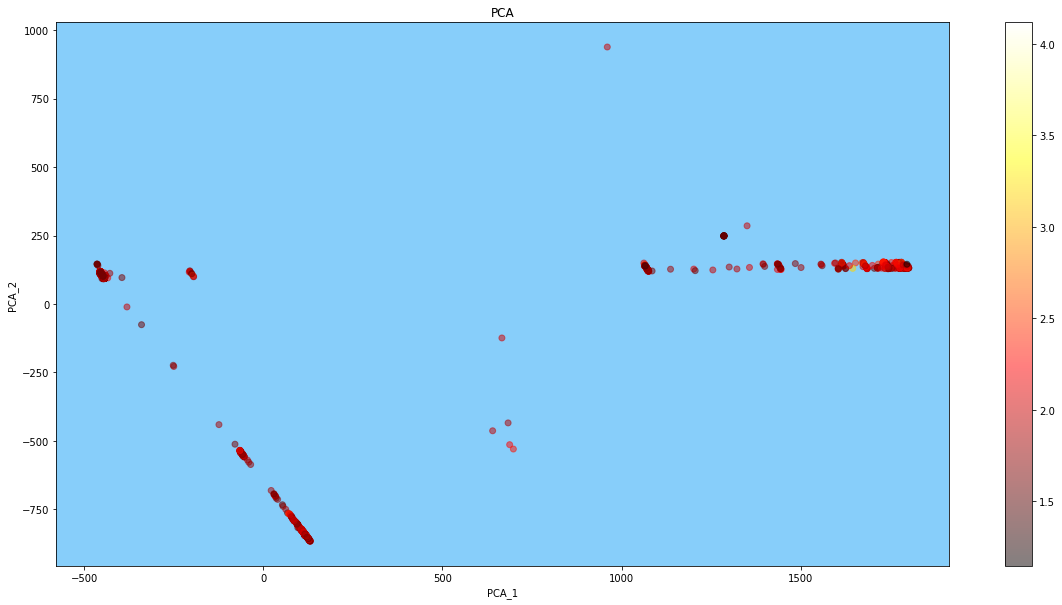

In [6]:
plt.figure(figsize=(20, 10))

ax = plt.axes()
ax.set_facecolor('lightskyblue')

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.log10(y_data), cmap='hot', alpha=0.5)
plt.title('PCA')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.colorbar()
plt.show()

Bien que la variance soit expliquée à hauteur de 94.5% sous 2 dimensions, il n’en demeure pas moins que ces deux dimensions ne permettent pas de séparer linéairement les données, ou bien de dégager une tendance au niveau des prix.

# Même chose avec t-SNE

In [7]:
tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(X_data)

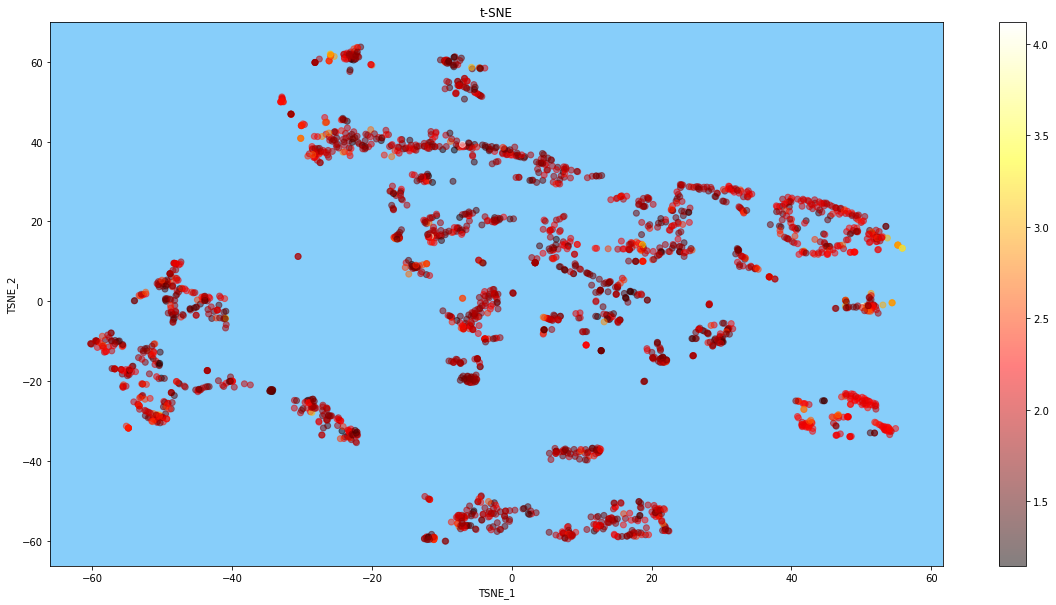

In [8]:
plt.figure(figsize=(20, 10))

ax = plt.axes()
ax.set_facecolor('lightskyblue')

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.log10(y_data), cmap='hot', alpha=0.5)
plt.title('t-SNE')
plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.colorbar()
plt.show()

**Remarque** : On commence à observer une tendance au niveau de la distribution des prix selon les deux dimensions réduites par t-SNE. Le cluster dans le coin bas droit du graphique indique des prix modestes. Tandis que plus dans le coin haut droit, nous avons des prix plus élevés. Un peu plus à droite du centre, nous retrouvons un léger cluster de prix faible.

# Avec Umap

In [9]:
reducer = umap.UMAP(n_components=2)

X_umap = reducer.fit_transform(X_data)

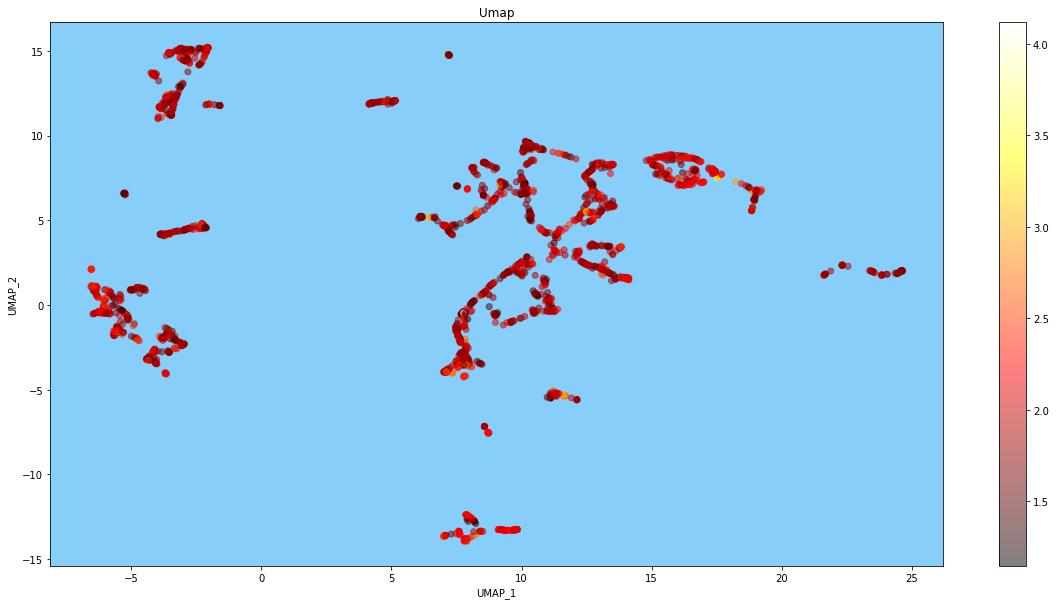

In [10]:
plt.figure(figsize=(20, 10))

ax = plt.axes()
ax.set_facecolor('lightskyblue')

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=np.log10(y_data), cmap='hot', alpha=0.5)
plt.title('Umap')
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.colorbar()
plt.show()

**Remarque** : La Umap nous ressort quelques clusters, sans réellement dégager de tendances selon les prix des locations.

# Split train / test

Dans notre cas nous utiliserons 90% en entrainement et 10% en test puisque nous avons peu de données.  
Dans cette analyse nous n’utilisons pas de technique de sélection de modèle puisque nous étudions simplement l’importance et l’impact des *features* sur un modèle.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.9, shuffle=True)

# Arbre de régression

Maintenant que nous avons tenté de réduire la dimensionnalité des données, essayons maintenant à l’aide de trois modèles de *Machine Learning* classiques de déterminer l’impact/importance des features sur le prix d’un logement en location.

In [12]:
tree = DecisionTreeRegressor() # Les paramètres par défaut sont suffisants
tree.fit(X_train, y_train)

tree.score(X_train, y_train), tree.score(X_test, y_test)

(0.9999240410973183, -0.16516613107439904)

L’arbre de régression sur-apprend, ce qui n’est pas optimal. Cependant, nous pouvons quand même observer quelles sont les features importantes pour réaliser ses splits.

In [13]:
tree.feature_importances_

array([8.28619139e-04, 9.03977213e-03, 2.19326931e-01, 2.35956482e-02,
       3.92234276e-02, 1.77668827e-01, 2.68324779e-03, 6.07204688e-04,
       1.18726021e-03, 2.04891317e-04, 6.01652197e-04, 3.51267108e-03,
       1.28532722e-03, 7.04213775e-04, 5.54213022e-04, 2.73540622e-03,
       3.63074896e-02, 7.03985486e-03, 2.31632970e-01, 1.05972387e-02,
       1.74913729e-03, 2.56813822e-04, 1.37738174e-04, 5.71017789e-05,
       3.47804009e-03, 2.53583492e-05, 3.03637771e-04, 4.95299193e-03,
       2.14333694e-01, 2.28148813e-03, 5.56061494e-09, 3.08712620e-03])

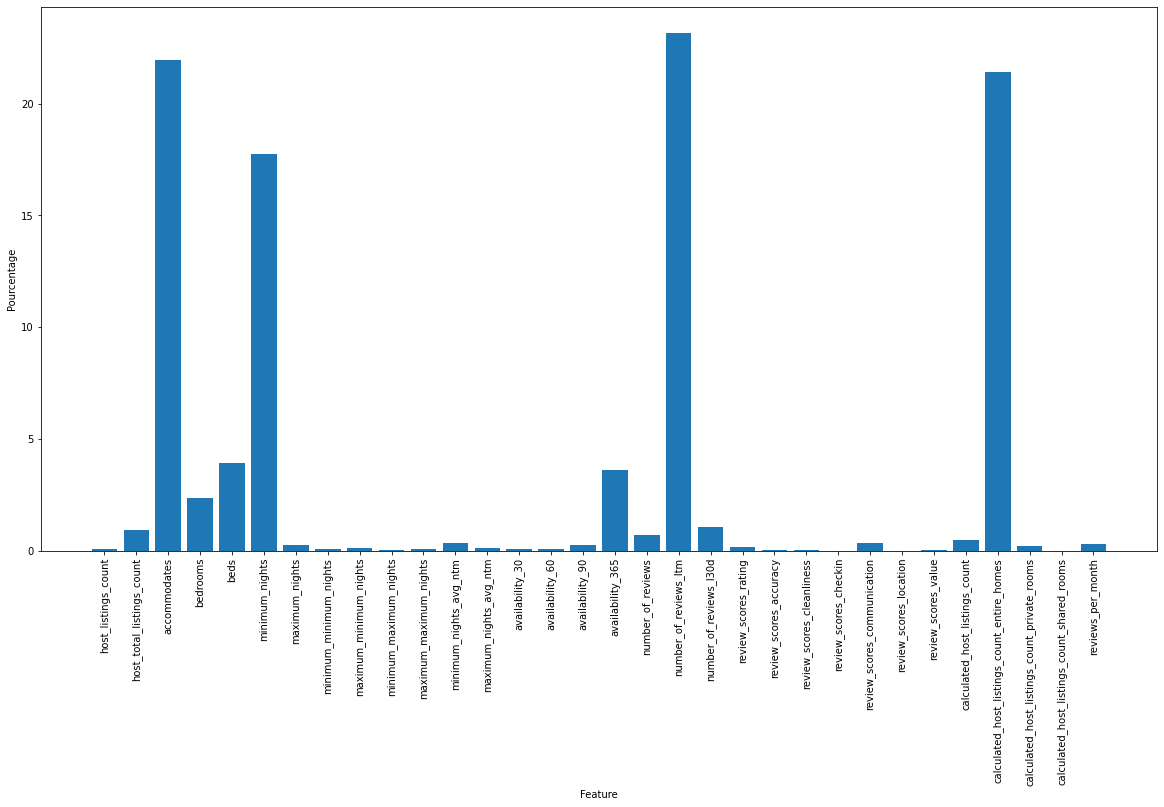

In [14]:
plt.figure(figsize=(20, 10))

plt.bar(features, height = tree.feature_importances_ * 100.)
plt.xticks(rotation=90)
plt.ylabel('Pourcentage')
plt.xlabel('Feature')
plt.show()

Étonnament l’arbre de régression n’est pas une méthode robuste puisqu’elle subit massivement l’overfitting. Chaque fois que nous lançons l’algorithme, des features différentes sont plus importantes que d’autres.

# Régression linéaire

In [15]:
lr = LinearRegression()

lr.fit(X_train, y_train)

lr.score(X_train, y_train),lr.score(X_test, y_test)

(0.02963102187567257, 0.052438330183730564)

Les coéfficients $R^2$ ne sont pas bons du tout. Ce qui indique qu’un modèle linéaire n’est pas adapté dans le cas de la prédiction des prix d’une location.

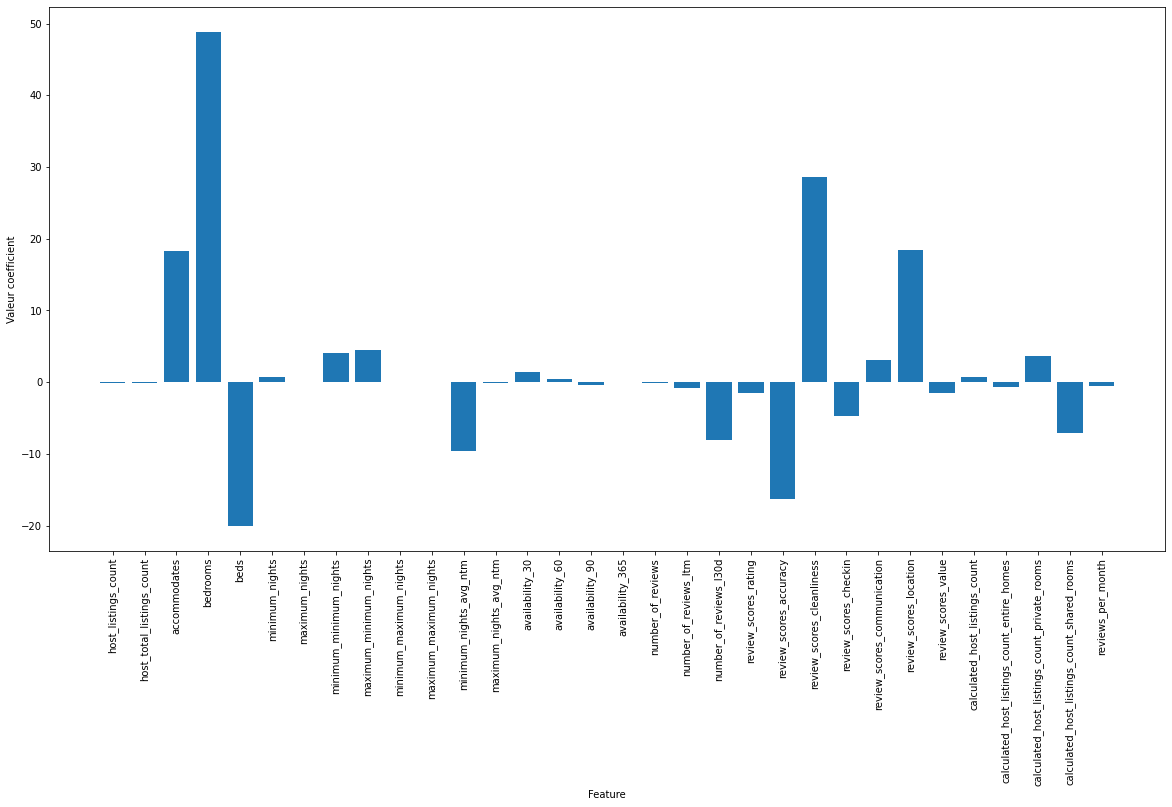

In [16]:
plt.figure(figsize=(20, 10))

plt.bar(features, height = lr.coef_)
plt.xticks(rotation=90)
plt.ylabel('Valeur coefficient')
plt.xlabel('Feature')
plt.show()

En étudiant les coefficients, il est étonant de voir que si l’on augmente le nombre de lits disponibles dans le logement, alors le prix diminue. Alors que si on augmente le nombre de chambre, le prix augmente $\Rightarrow$ Aucune cohérence !   
De plus, on note le même phénomène pour les reviews, certains scores ont l’air de faire baisser le prix du logement alors qu’on s’attend à ce que meilleure soit la note, meilleure soit le service alors plus élevé serait le prix.

Dernièrement, nous pouvons prévoir que le le Lasso éliminera les feautres concernant les disponibilités et les comptes de logements en location que possèdent l’hôte.

# Lasso

In [17]:
# Dans le cas de l’analyse, nous pouvons passer l’entièreté du jeu de données
eps = 1e-10

alphas_lasso, coefs_lasso, _ = lasso_path(X_data, y_data, eps=eps, n_alpha=1000, fit_intercept=True)
neg_log_alphas_lasso = -np.log10(alphas_lasso)

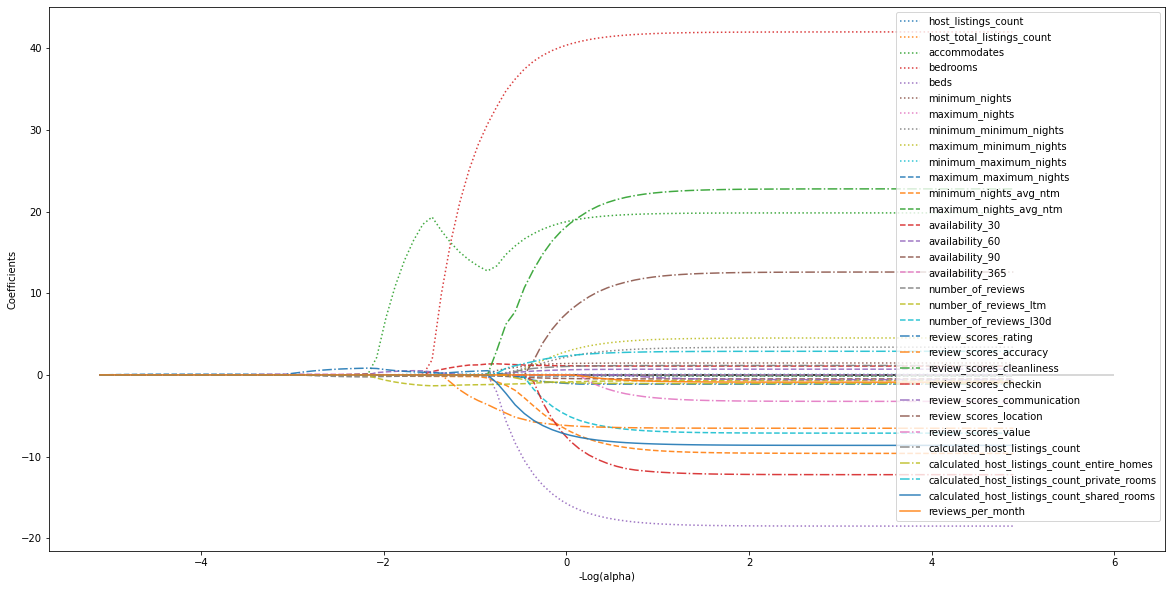

In [18]:
plt.figure(figsize=(20, 10))

colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
styles = ['dotted' for i in range(10)] + ['dashed' for i in range(10)] + ['dashdot' for i in range(10)] + ['solid' for i in range(2)]
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
cnt = 0
for i, (coef_l, c) in enumerate(zip(coefs_lasso, colors)):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c, linestyle=styles[i], label=features[i], alpha=0.90)
plt.hlines(0., 0, 6, linestyles='solid', colors='k')
plt.legend()
plt.show()

Étonnament la *feature* qui demeure le plus longtemps non nulle est le score des reviews. Ensuite en terme d’impact significatifs nous avons les accomodations, le nombre de chambre et le nombre de reviews dans les 12 derniers mois.

**Conclusion** : On remarque que ces 3 modèles ne sont pas optimales dans la résolution de la problématique suivant : *déterminer le prix de la location du logement en fonction de nos données*.

De plus, ils nous permettent difficilement de faire de la sélection de features, bien que nous possédons des courbes distinctes. Il faudrait utiliser des modèles non linéaire pour essayer de fixer le prix d’une location.

C’est pourquoi les modèles qui vont suivre (situés dans le répertoire *model*) vont être basés sur des réseaux de neurones, avec des fonctions d’activations non-continues.

Finalement, ne pas oublier que nous avons utilisé des raccourcis pour compléter les valeurs manquantes, et qu'un travail plus élaboré permettrait de mieux gérer ces dernières.